In [1]:
# Stable Diffusion 설치
!pip install -qq diffusers==0.31

# 위 코드 실행 시 지정된 버전의 diffusers 패키지와 그에 필요한 모든 종속성이 설치됨
# 이 패키지는 주로 이미지 생성 및 변환 작업에 사용되는 여러 diffusion모델을 포함하고 있으며
# 특히 stable diffusion모델을 사용할 수 있게 해줌, 설치가 완료되면 이 패키지를 통해
# 다양한 이미지 생성 및 편집 기능을 쉽게 활용할 수 있음

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.2 MB/s eta 0:00:00


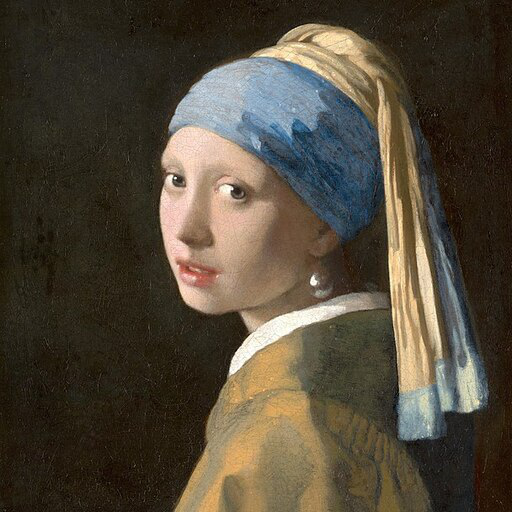

In [2]:
# 파이토치 라이브러리를 가져오는 명령어. 딥러닝 모델을 구축하고 학습시키는데 사용되는
# 오픈소스 머신러닝 프레임워크, 텐서연산과 GPU가속을 지원하기 위해 파이토치 사용함
import torch
# 파이프라인 클래스를 디퓨져 모듈에서 가져옴, 이 클래스는 제어 네트워크를 포함한 스테이블 디퓨젼 모델을
# 구현하며 이미지 생성 작업에 사용됨
from diffusers import StableDiffusionControlNetPipeline
# load_image함수를 디퓨져.유틸 모듈에서 가져옴, 이 함수는 이미지를 로드하고 이를 모델에 입력할 수 있는
# 형식으로 변환하는 역할을 함
from diffusers.utils import load_image

# 이미지 불러오기
# 로드이미지 함수를 호출하여 이미지를 로드함. url을 인자로 전달하여 웹에서 직접 이미지를 불러옴
# 아래의 url은 허깅 스페이스의 공식 이미지 데이터셋에서 제공하는 예제 이미지를 가리킴
# 로드된 이미지는 image변수에 저장되며 이후 이미지 생성 작업에 사용됨
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
# 마지막으로 로드된 이미지를 출력하여 확인함, 이 줄은 주로 디버깅 및 검증 목적으로 사용되며 주피터 노트북이나
# 대화형 환경에서는 이미지를 직접 시각화할 수 있음.
image
# 위 코드는 스테이블 디퓨젼 모델을 사용하여 이미지 생성 작업을 준비하는 초기 단계로 이미지를 로드하고 이를 모델에
# 입력할 준비를 함. 이후에는 이 이미지를 기반으로 새로운 이미지를 생성하거나 변형하는 작업을 수행할 수 있음

In [3]:
# GPU 메모리의 캐시를 비우는 작업
# 토치가 cuda모듈을 사용할 수 있게 함, 메모리의 캐시를 비움
torch.cuda.empty_cache()

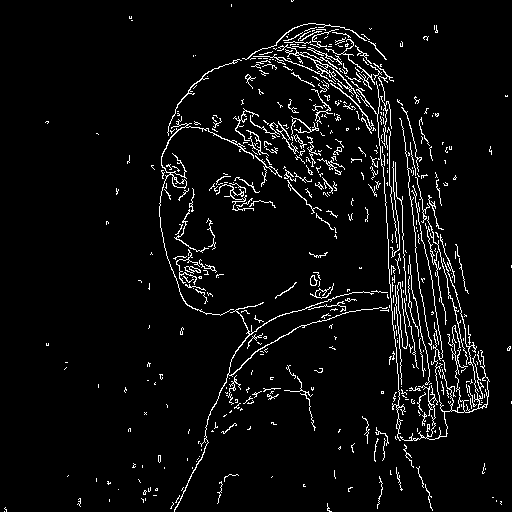

In [4]:
# openCV와 PIL 라이브러리를 사용하여 이미지를 Canny 엣지검출 알고리듬으로 처리하는 과정
# cv2 : openCV라이브러리로 컴퓨터 비전 작업을 위한 다양한 기능 제공
import cv2
# Python Imaging Library의 대체버전으로, 이미지 파일을 처리하고 변환하는데 사용됨
from PIL import Image
# 수치 계산을 위한 라이브러리, 다차원 배열 객체와 이를 다룰 수 있는 도구 제공
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 이 배열은 openCV함수들이 사용할 수 있는 형식으로 변환됨
image = np.array(image)

# 엣지 검출을 위한 임계값 지정, threshold를 지정합니다.
# 이 값들은 엣지를 검출할 때 사용되며, 낮은 임계점은 더 많은 엣지를 포함하고 있고 높은 임계값은
# 더 적은 엣지를 포함함
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
# Canny엣지 검출 수행 : 검출 알고리즘을 적용하여 이미지에서 엣지를 검출함, 결과는 흑백이미지로 반환함
image = cv2.Canny(image, low_threshold, high_threshold)
# 이미지 형식 변환
# 이미지 배열의 차원을 확장하여 (Height,Width,Channels)형태로 만듬. 여기서 None은 새로운 축을 추가하는 역할을 함
image = image[:, :, None]
# 동일한 배열 채널을 세 번 연결하여 RGB형식의 3채널 이미지로 만듬, 이렇게 하면 검출 결과를 색상 이미지로 변환할 수 있음.
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다.
# 엣지가 검출된 이미지를 출력함
canny_image
# 위 코드는 이미지를 Canny 검출 알고리즘을 사용하여 처리하고, 그 결과를 색상 이미지로 변환하여 보여주는 과정을 담고 있음
# 이를 통해 이미지에서 엣지를 강조하고 시각적으로 확인할 수 있음

In [5]:
# 이 코드는 stable diffusion 모델에 canny엣지 검출 결과를 활용한 제어 네트워크를 적용하며
# 이미지 생성 파이프라인을 설정하는 과정을 설명함
# stable diffusion 모델의 제어 네트워크 버전을 사용하기 위한 클래스
# controlnetmodel : 제어 네트워크를 정의하는 모델 클래스, 이 클래스는 외부 입력(예:엣지 맵)을 받아
# 모델의 출력에 영향을 줌
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
# canny 엣지 검출 제어 네트워크 로드
# from_pretrained(...) : 사전 학습된 제어 네트워크 모델을 로드함, lllyasviel/sd-controlnet-canny : 제어 네트워크의
# 허깅 스페이스 모델 체크포인트 id임, 이 체크포인트는 canny 엣지 검출 결과를 활용한 제어 네트워크를 포함하고 있음.
# torch_dtype=torch.float16 : 모델의 텐서 데이터 타입을 16비트 부동소수점으로 설정함, 이는 메모리 사용량을 줄이고
# gpu에서의 연산속도를 높이는데 도움이 됨
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
# from_pretrained(...) : 사전 학습된 스테이블 디퓨젼 모델과 제어 네트워크를 결합한 파이프라인을 설정함.
# runwayml/stable-diffusion-v1-5 : stable diffusion 모델의 허깅 스페이스 체크포인트 id
# controlnet=canny_controlnet : 앞서 로드한 canny 엣지 검출 제어 네트워크를 적용함
# torch_dtype=torch.float16 : 모델의 텐서 데이터 타입을 16비트 부동소수점으로 설정하여 메모리 효율성을 높임
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

# 위 코드는 canny 엣지 검출 결과를 활용한 제어 네트워크를 stable diffusion 모델에 적용하여 이미지 생성 시
# 엣지 정보를 반영할 수 있도록 설정. 이를 통해 생성된 이미지는 엣지 정보가 강화된 형태로 나타날 수 있음.
# 이 파이프라인은 이미지 생성 작업에서 엣지 세부 사항을 더욱 명확하게 표현하고자 할 때 유용함.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
# 이 코드는 canny 엣지 검출 결과를 활용한 제어 네트워크를 사용하여 이미지를
# 생성하는 과정을 설명함
# UniPCMultistepScheduler : 이 스케줄러는 diffusion모델의 학습 및 추론 과정에서 사용되는
# 스케줄링 전략을 제공함
from diffusers import UniPCMultistepScheduler
# 기존의 스케줄러를 UniPCMultistepScheduler로 교체함, from_config메소드를 사용하여
# 기존 스케줄러의 설정을 유지함
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
# 모델을 gpu로 이동함, to("cuda") : cuda는 CUDA를 통해 GPU를 사용하겠다는 의미
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
# torch.manual_seed(0) 랜덤 시드를 고정함, 이는 실험의 재현성을 보장하기 위해 사용됨.
# 시드 값을 0으로 설정하면, 항상 동일한 난수 시퀀스가 생성됨
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
# canny_pipe() : 이미지 생성을 위한 함수 호출
canny_image_1 = canny_pipe(
    # 생성할 이미지에 대한 설명을 문자열로 지정함
    prompt="disco dancer with colorful lights",
    # 추론과정에서 사용할 단계 수를 지정함, 더 많은 단계는 더 정교한 이미지를 생성할 수 있지만
    # 더 많은 계산자원을 소모함
    num_inference_steps=20,
    # 앞서 설정한 랜덤 시드를 사용하여 일관된 결과를 얻음
    generator=generator,
    # canny엣지 검출 결과를 제어 네트워크에 입력으로 사용함
    image=canny_image
# 생성된 이미지 중 첫 번째 이미지를 선택함
).images[0]

# 생성된 이미지를 저장합니다.
canny_image_1.save("/aiffel/aiffel/canny_image.png")

# 생성된 이미지를 출력합니다. 이 코드는 주로 디버깅 및 결과 확인을 위해 사용됨
canny_image_1
# 위 코드는 canny 엣지 검출 결과를 활용하여 제어 네트워크를 적용한 stable diffusion 모델을 사용해
# 이미지를 생성하는 전체 과정을 보여줌, 생성된 이미지는 지정된 설명과 엣지 정보를 반영하여 생성되며,
# gpu를 사용하여 효율적으로 처리됨

  0%|          | 0/20 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/canny_image.png'

In [9]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
# 제어 네트워크를 사용하여 특정 프롬프트에 기반한 이미지를 생성하는 과정을 설명함

# 랜덤 시드 설정 : 랜덤 시드를 고정함, 이는 실험의 재현성을 보장하기 위해 사용됨
# 시드 값을 0으로 설정하면 항상 동일한 난수 시퀀스가 생성됨
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
# canny_pipe(...) : 이미지 생성을 위한 함수 호출
canny_image_2 = canny_pipe(
    # 프롬프트 : 생성할 이미지에 대한 긍정적인 프롬프트를 지정함, 여기서는 부드러운 햇살 아래
    # 바리스타를 묘사하는 이미지를 생성하고자 함
    prompt="A barista in the soft sunlight",
    # 원하지 않는 요소를 명시하는 부정적인 프롬프트를 추가함, 여기서는 흐린 날씨를 피하고자 함
    negative_propmt = "cloudy",
    # 추론 과정에서 사용할 단계수를 증가시켜 더 정교한 이미지를 생성함, 단, 더 많은 단계는 더 많은 계산자원을 소모함
    num_inference_steps=40,
    # 가이드 스케일을 조정하여 생성의 안정성과 다양성 사이의 균형을 맞춤, 높은 값은 더 안정적인 결과를 제공하지만
    # 창의성은 감소할 수 있음.
    guidance_scale = 6.0,
    # 앞서 설정한 랜덤 시드를 사용하여 일관된 결과를 얻음
    generator=generator,
    # canny 엣지 검출 결과를 제어 네트워크에 입력으로 사용함
    image=canny_image
# 생성된 이미지 중 첫 번째 이미지를 선택함
).images[0]

# 생성된 이미지를 저장합니다.
canny_image_2.save("/aiffel/aiffel/canny_image2.png")

# 생성된 이미지를 출력합니다.
canny_image_2
# 위 코드는 canny엣지 검출 결과를 활용하여 제어 네트워크를 적용한 stable diffusion 모델을 사용해 특정 프롬프트와
# 부정적인 프롬프트를 반영한 이미지를 생성하는 과정을 보여줌. 또한, 하이퍼파라미터를 조정하여 생성의 품질과 특성을
# 제어할 수 있음, 생성된 이미지는 지정된 설명과 엣지 정보를 반영하며 gpu를 사용하여 효율적으로 처리됨

  0%|          | 0/40 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/canny_image2.png'

In [10]:
# 이미지 생성을 위한 디퓨전 모델을 사용하여 특정 프롬프트에 따라 이미지를 생성하는 과정
# 이 라인은 diffusers 패키지에서 Scheduler클래스를 임포트함 이 디퓨전 모델의 스케줄러 중 하나로
# 여러 단계로 학습을 진행할 수 있게 해줌
from diffusers import UniPCMultistepScheduler
# 이 라인은 canny_pipe 객체의 스케줄러를 UniPCMultistepScheduler로 설정함, 기존 스케줄러의
# 설정(config)을 그대로 사용하여 새로운 스케줄러를 생성함
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
# 이 라인은 canny_pipe객체를 GPU(cuda)로 이동시킴, 이를 통해 GPU를 사용하여 더 빠르게
# 연산을 수행할 수 있음
canny_pipe = canny_pipe.to("cuda")
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
# 이 라인은 파이토치의 랜덤시드값을 설정함, torch.manual_seed(0)는 항상 동일한 난수 시퀀스를
# 생성하도록 하여 결과 이미지가 동일하게 나오도록 함
generator = torch.manual_seed(0)

# 이미지를 생성합니다. canny_pipe객체에 다양한 인자를 전달하여 이미지를 생성함
canny_image_3 = canny_pipe(
    # 생성하고자 하는 이미지에 대한 프롬프트를 지정함
    prompt="a woman dancing under the light of the moon",
    #negative_propmt = "man, animal",
    # 생성 과정에서 사용할 추론 단계 수를 지정함, 이 값이 더 클수록 정교한 이미지를 생성할 수 있지만,
    # 연산 시간도 증가함.
    num_inference_steps=50,
    # 7.5 가이드 스케일을 설정함, 이 값은 생성 과정에서 가이드 강도를 조절하며,
    # 너무 크면 이미지가 왜곡될 수 있고, 너무 작으면 생성이 잘 되지 않을 수 있다.
    guidance_scale = 7.5,
    # 앞서 설정한 랜덤 시드를 사용하여 일관된 결과를 보장함
    generator=generator,
    # 초기 이미지를 지정함, 여기서는 canny_image라는 변수가 이미 정의되어 있어야 함
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
canny_image_3.save("/aiffel/aiffel/canny_image3.png")

# 생성된 이미지를 출력합니다.
canny_image_3

# 이 코드는 전체적으로 diffusion모델을 사용하여 특정 프롬프트에 기반한 이미지를 생성하고
# 그 결과를 저장 및 확인하는 과정을 담고 있음

  0%|          | 0/50 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/canny_image3.png'

In [11]:
# 이 코드는 주어진 프롬프트와 하이퍼파라미터를 사용하여 이미지를 생성하고 저장하는 과정을 설명함
# 이 라인은 diffusers 패키지에서 Scheduler클래스를 가져옴, 이 클래스는 Diffusion모델의 스케줄러 역할을 하며
# 여러 단계로 학습을 관리함
from diffusers import UniPCMultistepScheduler
# 이 라인은 canny_pipe객체의 스케줄러를 UniPCMultistepScheduler로 교체함, 기존 스케줄러의 설정을 그대로 사용하여
# 새 스케줄러를 생성함
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
# 이 라인은 canny_pipe객체를 GPU(cuda)로 이동시켜, GPU가속을 활용할 수 있도록 함
canny_pipe = canny_pipe.to("cuda")
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요.

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
# 이 라인은 파이토치의 랜덤 시드를 설정함, torch.manual_seed(3)를 사용하면 매번 실행할 때마다 동일한 난수를
# 생성하게 되어, 이미지 생성결과가 일관되게 유지됨
generator = torch.manual_seed(3)

# 이미지를 생성합니다.
# canny_pipe(...): 이 라인은 실제 이미지 생성을 수행함, canny_pipe함수에 여러 인자를 전달하여
# 이미지를 생성함
canny_image_4 = canny_pipe(
    # 생성할 이미지에 대한 프롬프트를 지정함
    prompt="a woman dancing under the light of the moon",
    # 원하지 않는 요소를 명시하는 네거티브 프롬프트를 추가함, 여기서는 "포커페이스"와 같은 요소가 포함되지 않도록 함
    negative_propmt = "a poker face",
    # 생성과정에서 사용할 추론 단계수를 설정함, 이 값이 더 클수록 더 정교한 이미지를 생성할 수 있지만 연산 시간도 증가함
    num_inference_steps=50,
    # 가이드 스케일을 설정함, 이 값은 생성 과정에서의 가이드 강도를 조절하며, 너무 크면 이미지가 왜곡될 수 있고
    # 너무 작으면 생성이 잘 되지 않을 수 있다.
    guidance_scale = 5.5,
    # 앞서 설정한 랜덤 시드를 사용하여 일관된 결과를 보장함
    generator=generator,
    # 초기 이미지를 지정함, 이 변수는 코드 상단에 정의되어 있어야 함
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
canny_image_4.save("/aiffel/aiffel/canny_image4.png")

# 생성된 이미지를 출력합니다.
canny_image_4
# 위 코드는 전반적으로 특정 프롬프트와 하이퍼파라미터를 사용하여 이미지를 생성하고
# 그 결과를 파일로 저장하며 최종적으로 생성된 이미지를 출력하는 과정을 담고 있음

  0%|          | 0/50 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/canny_image4.png'

In [1]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

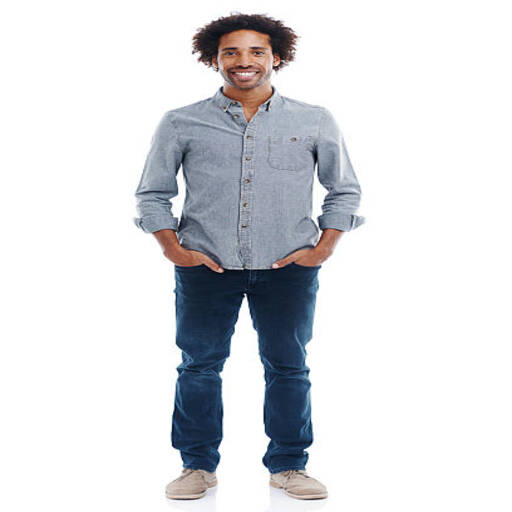

In [2]:
# 이 코드는 load_image 유틸리티 함수를 사용하여 이미지를 로드하고 표시하는 과정을 설명함
# 이 라인은 diffusers 패키지의 utils 모듈에서 load_image함수를 임포트함, 이 함수는 url 또는
# 파일 경로로부터 이미지를 로드하는 기능을 제공함.
from diffusers.utils import load_image
# load_image(...) : 이 라인은 load_image함수를 호출하여 이미지를 로드함
# openpose_image : 이 라인은 로드된 이미지를 출력함, 이 코드는 주로 주피터 노트북이나 파이선 인터프리터에서
# 실행될 때 유용하며, 이미지를 바로 확인할 수 있게 해줌
openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image
# 이 코드는 특정 url에서 이미지를 다운로드하고 그것을 메모리에 로드한 후 해당 이미지를 출력하는 간단한
# 예제임, 이를 통해 이미지를 쉽게 시각화할 수 있음

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

cuda


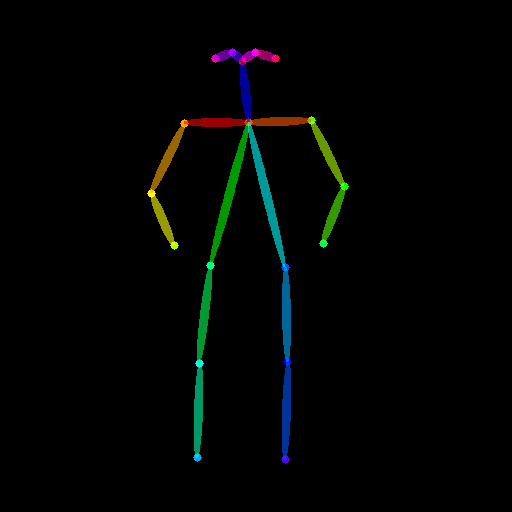

In [3]:
# OpenposeDetector 모델을 사용하여 이미지에서 인체의 자세를 검출하는 과정을 설명함
# 이 라인은 controlnet_aux 모듈에서 OpenposeDetector클래스를 임포트함. 이 클래스는 인체 자세를
# 검출하는데 사용되는 모델
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
# 이 라인은 불러온 openpose 모델을 사용하여 이미지의 인체자세를 검출함. openpose_image변수에는
# 이전에 로드된 이미지가 저장되어 있으며 이 이미지를 입력으로 하여 자세를 분석한 결과를
# 다시 openpose_image에 저장함
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
# 이 라인은 자세가 검출된 이미지를 출력함, 이 코드는 주로 주피터 노트북이나 파이선
# 인터프리터에서 실행될 때 유용하며 이미지 상의 인체 키포인트와 뼈대를 시각화하여
# 확인할 수 있음
openpose_image = openpose(openpose_image)
openpose_image
# 이 코드는 이미지에서 사람의 자세를 자동으로 인식하고 시각화하는 과정을 간단하게 보여줌.
# 이를 통해 이미지 내 인체의 주요 관절과 윤곽선을 쉽게 확인할 수 있음

In [4]:
# 이 코드는 ~Pipeline와 ~NetModel을 사용하여 이미지 생성 파이프라인을 설정하는 과정을 설명함
# 이 라인은 diffusers 패키지에서 필요한 두 개의 클래스를 임포트함, NetPipeline은 스테이블 디퓨전 모델의
# 파이프라인을 정의하며, 콘트롤넷모델은 제어 네트워크 모델을 나타냄
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
# 이 라인은 사전학습된 콘트롤넷 모델을 불러옴. -openpose는 OpenPose를 활용한 제어 네트워크를 포함한
# 사전학습된 모델의 이름,torch.float16은 텐서의 데이터타입을 16비트 부동소수점 형식으로 설정하여
# 메모리 사용량과 계산속도를 최적화함
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
# .pretrained(...): 이 라인은 사전학습된 StableDiffusionNetPipeline을 생성함
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    # 모델 임포트 : 기본 stable diffusion 모델의 이름
    # 제어 네트워크 추가 : 앞서 로드한 OpenPose 제어 네트워크를 추가하여 이미지 생성 시 인체 자세를 더 잘 반영할 수
    # 있도록 함.
    # 데이터 타입 설정 : torch.float16은 마찬가지로 메모리 효율성을 높이기 위해 텐서의 데이터타입을 16비트로 설정함
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)
# 위 코드는 이미지 생성 파이프라인을 설정하는 초기단계를 다루며, 특히 OpenPose를 활용한 제어 네트워크를
# 통합하여 생성된 이미지의 인체 자세를 더욱 자연스럽게 만들 수 있도록 준비함, 이 파이프라인을 통해
# 생성되는 이미지는 인체의 구조와 움직임을 더 정확하게 반영할 수 있음

NameError: name 'torch' is not defined

In [5]:
# 파이프라인을 사용하여 특정 프롬프트에 따라 이미지를 생성하는 과정을 설명함.
# 이 라인은 diffusers 패키지에서 -scheduler클래스를 임포트함, 이 스케줄러는 이미지 생성 과정에서
# 여러 단계로 학습을 진행할 수 있게 해줌
from diffusers import UniPCMultistepScheduler
# 이 라인은 openpose_pipe 객체의 스케쥴러를 scheduler로 교체함, 기존 스케줄러의 설정을 그대로 사용하여
# 새 스케줄러를 생성함
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
# 이 라인은 openpose_pipe 객체를 GPU(cuda)로 이동시켜 GPU가속을 활용할 수 있도록 함
openpose_pipe = openpose_pipe.to("cuda")
# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다.
# 이 라인은 파이토치의 랜덤시드를 설정함, torch.manual_seed(0)를 사용하면 매번 실행할 때마다
# 동일한 난수를 생성하게 되어, 이미지 생성결과가 일관되게 유지됨
generator = torch.manual_seed(0)
#프롬프트를 작성합니다.
# 이 라인은 이미지 생성을 위한 프롬프트를 정의함, 여기서는 "백화점 쇼케이스에 전시된 모델"이라는 문장을 사용함
prompt =  "Model displayed at department store showcase"
# 이 라인은 생성된 이미지에서 피하고자 하는 요소를 명시하는 네거티브 프롬프트를 정의함, 여기서는 "강렬한 빛"이
# 포함되지 않도록 설정
negative_prompt = "intense light"
# 이미지를 생성합니다.
# 이 라인은 실제로 이미지를 생성하는 부분
openpose_image1 = openpose_pipe(
    # 프롬프트와 네거티브 프롬프트 전달
    prompt=prompt,
    negative_prompt=negative_prompt,
    # 초기 이미지를 지정함, 이 변수는 로드된 이미지로 자세 정보가 포함된 이미지
    # 생성된 첫 번째 이미지는 변수에 저장됨
    image=openpose_image
).images[0]
# 생성된 이미지를 출력합니다.
openpose_image1
# 위 코드는 전체적으로 특정 프롬프트와 초기 이미지를 기반으로 이미지를 생성하고 그 결과를 출력하는 과정을
# 담고 있음, OpenPose 제어 네트워크를 사용하여 인체 자세를 고려한 이미지 생성을 수행함

NameError: name 'openpose_pipe' is not defined

In [7]:
# 이 코드는 -pipeline을 사용하여 특정 프롬프트와 초기 이미지를 기반으로 이미지를
# 생성하는 과정을 설명함
# 이 라인은 openpose_pipe 객체의 스케줄러를 -Scheduler로 교체함, 기존 스케줄러의 설정을 그대로 사용하여
# 새 스케줄러를 생성함
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
# 이 라인은 _pipe 객체를 GPU(cuda)로 이동시켜 GPU가속을 활용할 수 있도록 함
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다.
# 이 라인은 파이토치 랜덤시드를 설정함, torch.manual_seed(0)를 사용하면 매번 실행할 때마다
# 동일한 난수를 생성하게 되어, 이미지 생성결과가 일관되게 유지됨
generator = torch.manual_seed(0)

#프롬프트를 작성합니다.
# 이 라인은 이미지 생성을 위한 프롬프트를 정의함
prompt =  "Model displayed at department store showcase"
# 이 라인은 생성된 이미지에서 피하고자 하는 요소를 명시하는 네거티브 프롬프트를 정의함
# 여기서는 "강렬한 빛"이 포함되지 않도록 설정하
negative_prompt = "intense light"

# 이미지를 생성합니다.
# (...) 이 라인은 실제로 이미지를 생성하는 부분
openpose_image2 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    # 제어 네트워크의 조건부 스케일을 설정함, 이 값은 제어 네트워크의 영향을
    # 조절하며 일반적으로 0.5에서 2.0사이의 값을 사용함, 여기서는 기본값인 1.0을 사용함
    controlnet_conditioning_scale=1.0,   # 보통 0.5 ~ 2.0 사이에서 조정
    # 생성 과정에서 사용할 추론 단계수를 지정함, 이 값은 생성의 정밀도와 속도에 영향을 미치며
    # 필요에 따라 조정할 수 있음
    num_inference_steps=30,
    # 앞서 설정한 랜덤 시드를 사용하여 일관된 결과를 보장함
    generator=generator,
    # 초기 이미지를 지정함, 이 이미지는 자세 정보가 포함된 OpenPose 이미지임
    image=openpose_image                # ← OpenPose 조건 이미지 입력
).images[0]

# 생성된 이미지를 출력합니다.
openpose_image2
# 위 코드는 전체적으로 특정 프롬프트와 초기 이미지를 기반으로 이미지를 생성하고
# 그 결과를 출력하는 과정을 담고 있음, 특히, OpenPose 제어 네트워크를 활용하여
# 인체의 자세정보를 반영한 이미지 생성을 수행함

NameError: name 'openpose_pipe' is not defined

In [8]:
# ~Pipeline을 사용하여 특정 프롬프트와 초기 이미지를 기반으로 이미지를 생성하는
# 과정을 설명함
# 이 라인은 diffusers 패키지에서 Scheduler클래스를 임포트함, 이 스케줄러는 이미지 생성 과정에서
# 여러 단계로 학습을 진행할 수 있게 해줌
from diffusers import UniPCMultistepScheduler
# 이 라인은 파이토치 라이브러리를 임포트함, 이는 랜덤 시드를 설정하는데 사용됨
import torch

# 스케줄러 교체 & 모델을 CUDA로 이동
# 이 라인은 _pipe 객체의 스케줄러를 Scheduler로 교체함, 기존 스케줄러의 설정을 그대로 사용하여 새 스케줄러를 생성함
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
# 이 라인은 _pipe 객체를 GPU(cuda)로 이동시켜 GPU가속을 활용할 수 있도록 함
openpose_pipe = openpose_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 고정
# 이 라인은 파이토치의 랜덤 시드를 설정함
# _seed(0)를 사용하면 매번 실행할 때마다 동일한 난수를 생성하게 되어 이미지 생성결과가 일관되게 유지됨
generator = torch.manual_seed(0)

# 프롬프트 설정
# 이 라인은 이미지 생성을 위한 프롬프트를 정의함, 여기서는 "우산을 들고 있는 밝은 갈색 피부색의 사람, 버스 정류장에 서 있음"
# 이라는 문장을 사용함
prompt = "light brown, holdding an umbrella, at bus stop"
# 이 라인은 생성된 이미지에서 피하고자 하는 요소를 명시하는 네거티브 프롬프트를 정의함, 여기서는 ""등의 요소가
# 포함되지 않도록 설정함
negative_prompt = "low quality, blurry, distorted, deformed"

# 이미지 생성
# openpose_pipe(...) 이 라인은 실제로 이미지를 생성하는 부분
openpose_image3 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    # 제어 네트워크의 조건부 스케일을 설정함, 이 값은 제어 네트워크의 영향을 조절하며
    # 일반적으로 0.5에서 2.0사이의 값을 사용함, 여기서는 1.5를 사용하여 제어 네트워크의
    # 영향을 중간 정도로 설정함
    controlnet_conditioning_scale=1.5,   # 보통 0.5 ~ 2.0 사이에서 조정
    # 생성 과정에서 사용할 추론 단계수를 지정함, 이 값은 생성의 정밀도와 속도에 영향을 미치며
    # 필요에 따라 조정할 수 있음
    num_inference_steps=30,
    # 앞서 설정한 랜덤 시드를 사용하여 일관된 결과를 보장함
    generator=generator,
    # 초기 이미지를 지정함, 이 이미지는 자세 정보가 포함된 OpenPose 이미지임
    image=openpose_image                # ← OpenPose 조건 이미지 입력
).images[0]

# 이미지 출력
openpose_image3
# 위 코드는 전체적으로 특정 프롬프트와 초기 이미지를 기반으로 이미지를 생성하고
# 그 결과를 출력하는 과정을 담고 있음, 특히, OpenPose 제어 네트워크를 활용하여
# 인체의 자세 정보를 반영한 이미지 생성을 수행함

NameError: name 'openpose_pipe' is not defined

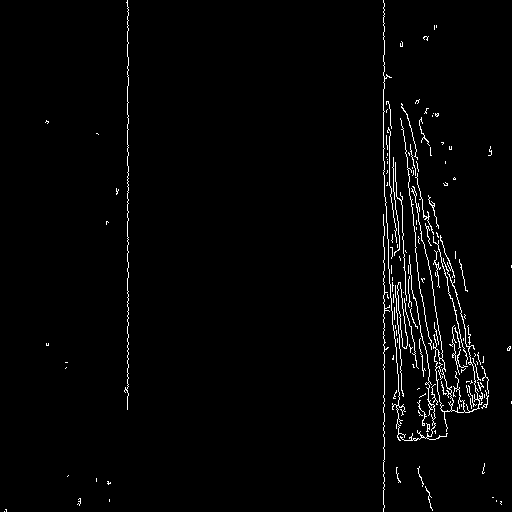

In [9]:
# 위 코드는 주어진 이미지를 불러오고 canny엣지 검출 알고리듬을 사용하여 엣지를 강조한
# 이미지를 생성하는 과정을 설명함
# diffusers, PIL, cv2, numpy라이브러리를 임포트함, 이 라이브러리들은 이미지 처리와 관련한
# 다양한 기능을 제공함
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# Q. 코드를 작성해 보세요.
# 이미지를 불러오세요. load_image함수를 사용하여 url에서 이미지를 불러옴
canny_image = load_image("https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png")
# 불러온 이미지를 (512,512)크기로 리사이즈함
canny_image = canny_image.resize((512, 512))

#threshhold를 지정합니다. Canny엣지 검출에 사용할 낮은 임계값과 높은 임계값을 설정함
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다. GRAYSCALE로 변경.
# 이미지를 회색조(L)로 변환하고 넘파이 배열로 변환함, 이는 canny엣지 검출을 위해 필요함
canny_image = np.array(canny_image.convert("L"))

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다.
# 이미지 중앙부분을 지우기 위해 시작점과 끝점을 계산하고 해당 영역의 픽셀값을 0으로 설정하여
# 검은색으로 만듬
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다.
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold) # Canny 엣지 검출
canny_image = np.stack([canny_image] * 3, axis= -1)
canny_image = Image.fromarray(canny_image)

canny_image
# 이 코드는 주어진 이미지를 불러와서 canny엣지 검출을 통해 엣지를 강조하고
# 특정 영역을 검은색으로 덮어씀으로써 원하는 형태의 이미지를 생성함

cuda


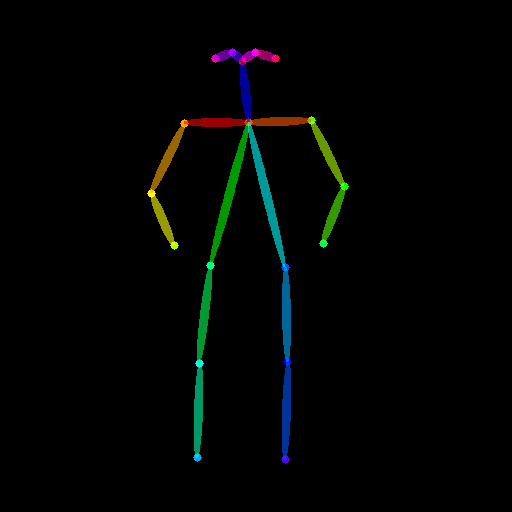

In [10]:
# OpenposeDetector를 사용하여 이미지 내 인체의 자세를 검출하는 과정을 설명함
from controlnet_aux import OpenposeDetector
# load_image는 이미지를 불러오는데 사용함
from diffusers.utils import load_image

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다. load_image함수를 사용하여 주어진 url에서 이미지를 불러옴. 이 이미지는 인체가 포함된 사진임
openpose_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png")

# OpenposeDetector를 사전 학습된 버전으로 로드함, ("")는 OpenposeDetector의 특정 버전을 참조함
# 로드된 OpenposeDetector 모델을 사용하여 현재 이미지에 대해 인체 포즈를 감지함, 이 과정에서
# 모델은 이미지 내의 인체 주요 관절들을 찾아내고 이를 기반으로 포즈를 추정함
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)
# 최종적으로 인체 포즈가 검출된 이미지를 반환함, 이 이미지는 원본이미지에 인체 포즈 정보가
# 추가된 형태
openpose_image
# 위 코드는 이미지에서 인체의 포즈를 자동으로 감지하고 이를 시각화하기 위한 기본적인 프로세스를
# 보여줌. OpenposeDetector는 이미지 내의 인체 주요 관절 위치를 찾아내어 이를 통해 인체의 자세를
# 파악할 수 있게 해줌

In [11]:
# 이 코드는 두 개의 제어망(ControlNet)을 사용하여 이미지를 생성하는 과정을 설명함
# 필요한 모듈을 임포트함, -Pipeline은 이미지 생성 파이프라인을 정의하며, -Model은 제어망을 정의하고
# -Scheduler는 스케줄러를 정의함
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.
# 두 개의 사전학습된 제어망 모델을 로드함, 각각 canny엣지 검출과 Openpose포즈 감지를 위한 모델
# 이 모델들을 controlnets에 저장함
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
controlnets = [controlnet_canny, controlnet_openpose]

# 리스트 controlnets를 파이프라인으로 전달합니다.
# 이미지 생성 파이프라인을 로드함, 기본 모델은 -diffusion-v-1-5이며, 제어망 리스트와 torch.float16을 사용하여
# 연산을 최적화함
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)
# 스케줄러를 설정하고, 파이프라인을 GPU(cuda)로 이동시켜 연산 속도를 높임.
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 프롬프트는 생성하고자 하는 이미지를, 부정 프롬프트는 피하고자 하는 내용
prompt = "A woman walking in an aquarium, fairy tale, ultra detailed, 4k"
negative_prompt = "blurry, distorted, low quality, extra limbs"

# seed를 지정합니다. 난수 생성기의 시드를 고정하여 결과의 재현성을 보장함
generator = torch.manual_seed(0)
# 앞서 생성한 Openpose와 Canny엣지 검출 이미지를 리스트로 묶음, 이 이미지들은 제어 조건으로 사용됨
images = [openpose_image, canny_image]

# 이미지를 생성합니다.
# 프롬프트, 부정 프롬프트, 인퍼런스 단계 수, 그리고 제어 조건 이미지를 파이프라인에 전달함
# 각 제어망의 영향력을 조절하기 위해 _scale을 설정함
image_1 = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    generator=generator,
    image=images,  # ControlNet condition 입력
    controlnet_conditioning_scale=[1.0, 0.8]  # 각 controlnet의 영향력 조절
).images[0]

# 생성된 이미지를 저장합니다.
image_1.save("/aiffel/aiffel/multi_controlnet_output_1.png")

# 생성된 이미지를 출력합니다.
image_1
# 위 코드는 두 개의 제어망을 동시에 사용하여 특정 조건 하에 이미지를 생성하는 방법을 보여줌
# canny 엣지와 Openpose 포즈 정보를 활용하여 보다 정교한 이미지 생성을 가능하게 함

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/multi_controlnet_output_1.png'

In [12]:
# 이 코드는 두 개의 제어망(ControlNet)을 사용하여 이미지를 생성하는 과정을 설명함
# 필요한 모듈을 임포트함, -Pipeline은 이미지 생성 파이프라인을 정의하며, -Model은 제어망을
# 정의하고 -Scheduler는 스케줄러를 정의함
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.
# 두 개의 사전 학습된 제어망 모델을 로드함, 각각 Canny엣지 검출과 Openpose포즈 감지를 위한 모델임
# 이 모델들을 controlnets에 저장함
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
controlnets = [controlnet_canny, controlnet_openpose]

# 리스트 controlnets를 파이프라인으로 전달합니다.
# 이미지 생성 파이프라인을 로드함, 기본 모델은 -diffusion-v1-5이며, 제어망 리스트와 torch.float16을 사용하여
# 연산을 최적화함
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)
# 스케줄러를 설정하고 파이프라인을 GPU(cuda)로 이동시켜 연산 속도를 높임
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 생성할 이미지에 대한 프롬프트와 부정 프롬프트를 정의함, 프롬프트는 생성하고자 하는
# 이미지의 내용을, 부정 프롬프트는 피하고자 하는 내용을 기술함
prompt = "A woman walking in an aquarium, fairy tale, ultra detailed, 4k"
negative_prompt = "blurry, distorted, low quality, extra limbs"

# 난수 생성기의 seed를 고정하여 결과의 재현성을 보장함
generator = torch.manual_seed(0)
# 앞서 생성한 canny엣지 검출 이미지와 Openpose포즈 이미지를 리스트로 묶음, 이 이미지들은
# 제어조건으로 사용됨
images = [canny_image, openpose_image]
# 이미지를 생성을 수행함, 프롬프트, 부정 프롬프트, 인퍼런스 단계수, 그리고 제어 조건 이미지를
# 파이프라인에 전달함, 각 제어망의 영향력을 조절하기 위해 _scale을 설정함
image_2 = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    generator=generator,
    image=images,  # ControlNet condition 입력
    controlnet_conditioning_scale=[1.0, 0.8]  # 각 controlnet의 영향력 조절
).images[0]
# 생성된 이미지를 저장합니다.
# image.save("/content/drive/MyDrive/aiffel/multi_controlnet_output1.png")
image_2.save("/aiffel/aiffel/multi_controlnet_output_2.png")
# 생성된 이미지를 출력합니다.
image_2
# 위 코드는 두 개의 제어망을 동시에 활용하여 특정 조건 하에 이미지를 생성하는 방법을
# 보여줌, canny엣지와 openpose포즈 정보를 활용하여 보다 정교한 이미지 생성을 가능하게 하며
# 생성된 이미지는 지정된 경로에 저장되고 출력됨

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/multi_controlnet_output_2.png'

In [13]:
# Stable Diffusion 설치
# !는 주피터 노트북이나 구글 코랩같은 대화형 환경에서만 사용되는 특수한 명령어임,
# 이는 현재 환경에서 명령어를 실행시키겠다는 의미
# pip install은 파이선 패키지를 설치하는 명령어, -qq옵션은 설치 과정 중 메시지를 최소화하여 사용자에게
# 표시되지 않도록 함, 이는 설치 과정이 길어질 때 유용함
# 특정 버전을 명시하면 코드의 일관성을 유지하고 예기치 않은 버전 충돌을 방지할 수 있음
!pip install -qq diffusers==0.31
# 주로 제어망 관련 기능을 확장하는데 사용함
!pip install controlnet-aux==0.0.1
# 이 두 줄의 코드는 스테이블 디퓨젼 및 관련 제어망 패키지를 설치하여 이미지 생성 작업을 수행할 수 있는
# 환경을 구성하는데 필수적임, 이러한 패키지들이 설치되어 있어야만 이후의 이미지 생성 코드가 정상적으로
# 작동할 수 있음

In [14]:
# 파이토치 라이브러리를 임포트함, 주로 딥러닝 모델을 구축하고 훈련하는데 사용되며
# GPU가속을 지원하여 대규모 연산을 빠르게 처리할 수 있음
import torch
# 디퓨젼 모델의 제어망 파이프라인을 정의하는 클래스, 이 클래스는 이미지 생성시 다양한
# 제어조건을 적용할 수 있도록 도와줌
from diffusers import StableDiffusionControlNetPipeline
# load_image함수는 이미지 파일을 불러오는 기능을 제공함, 이 함수는 url이나 파일 경로로부터
# 이미지를 읽어올 수 있음
from diffusers.utils import load_image
# Python Imaging Library은 파이선에서 이미지 처리를 위한 라이브러리임, Image모듈은
# 이미지 파일을 열고, 수정하고, 저장하는 등의 작업을 지원함
from PIL import Image
# OpenCV를 임포트함, 컴퓨터 비전 작업을 위한 다양한 기능을 제공하는 라이브러리.
# 이미지 및 비디오 처리, 객체 탐지, 얼굴 인식 등을 쉽게 구현할 수 있음
import cv2
# 다차원 배열과 행렬 연산을 효율적으로 처리할 수 있는 라이브러리, 이미지 데이터를
# 배열 형태로 다루거나 수치 계산을 할 때 많이 사용됨
import numpy as np
# 인체 포즈를 감지하는 모델, 이 모델은 이미지에서 사람의 주요 관절을 인식하고
# 이를 기반으로 포즈를 추정함
from controlnet_aux import OpenposeDetector
# -Model은 제어망을 정의하는 클래스, 이 클래스는 이미지 생성 시 외부 제어 신호를 통합하여
# 더 정교한 결과를 얻을 수 있도록 도와줌
# -Scheduler는 이미지 생성 과정에서 사용되는 스케줄러임. 이 스케줄러는 생성 과정을
# 여러 단계로 나누어 점진적으로 진행하도록 조정함
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
# 이 임포트 구문은 이미지 생성 및 처리 작업에 필요한 모든 도구와 라이브러리를 준비하는데 사용됨
# 이를 통해 이후에 이미지 불러오기, 포즈 감지, 엣지 검출, 그리고 제어망을 사용한 이미지 생성 등의
# 작업을 수행할 수 있음

In [15]:
# 포즈 이미지 링크
# https://search.pstatic.net/common/?src=http%3A%2F%2Fblogfiles.naver.net%2FMjAyNTA0MDhfOTUg%2FMDAxNzQ0MDg5NDM2MDEz.U_29wsnZTiXTfKK2BQFH5wvGEpGrWm4a7ax31vKdN1og.Feox-RLfweok-LbCgTFyBiFvHMNU3rUkPh4yKM-CYEAg.PNG%2Fimage.png&type=sc960_832
# 윤곽선 이미지 링크
# https://search.pstatic.net/common/?src=http%3A%2F%2Fblogfiles.naver.net%2FMjAxNzA3MTdfMTA1%2FMDAxNTAwMjk2MDA5NDgz.CJ70rm-KOC4QE1g_6Ug-rLMhVHYZR2T15s7GxIXMyXIg.W4-Lw815IalxHG2jJPubvdNz_a7P1OXpVAKyZN5Vbtsg.JPEG.alsdk0404%2F62684637_p0.jpg&type=sc960_832

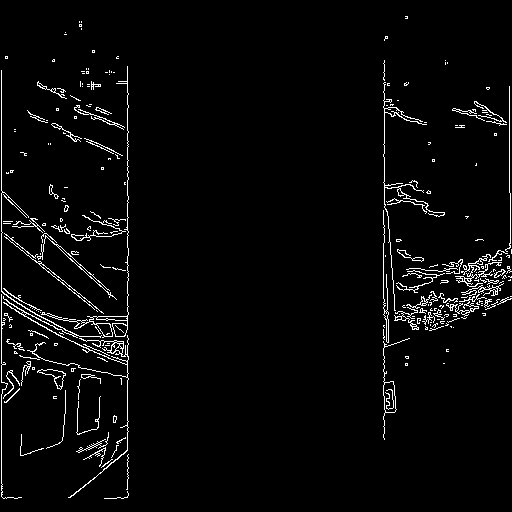

In [16]:
# 이 코드는 주어진 url에서 이미지를 불러오고 canny엣지 검출을 통해 엣지를 강조한
# 이미지를 생성하는 과정을 설명함.
# 이미지를 불러오기.
# load_image함수를 사용하여 주어진 url에서 이미지를 불러옴. 이 이미지는 블로그 포스트에서
# 가져온 것으로 보임
canny_image = load_image("https://search.pstatic.net/common/?src=http%3A%2F%2Fblogfiles.naver.net%2FMjAxNzA3MTdfMTA1%2FMDAxNTAwMjk2MDA5NDgz.CJ70rm-KOC4QE1g_6Ug-rLMhVHYZR2T15s7GxIXMyXIg.W4-Lw815IalxHG2jJPubvdNz_a7P1OXpVAKyZN5Vbtsg.JPEG.alsdk0404%2F62684637_p0.jpg&type=sc960_832")
# 불러온 이미지를 (512,512)크기로 리사이즈함, 이는 이후의 이미지 처리를
# 위한 전처리 단계
canny_image = canny_image.resize((512, 512))

# threshhold를 지정합니다. canny엣지 검출에 사용할 낮은 임계값과 높은 임계값을 설정
# 이 값들은 엣지 검출의 민감도를 조절함
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다. GRAYSCALE로 변경. 이는 canny엣지 검출을 위해 필요함
canny_image = np.array(canny_image.convert("L"))

# 이미지의 중앙 부분을 지우기 위해 시작점과 끝점을 계산하고 해당 영역의 픽셀 값을 0으로
# 설정하여 검은색으로 만듬, 이는 인체감지포즈를 넣기 위한 준비 단계
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 앞서 설정한 낮은 임계값과 높은 임계값을 사용함
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold) # Canny 엣지 검출
# 회색조 이미지를 rgb형식으로 변환함, 이는 pil에서 이미지를 저장하기 위해 필요함
canny_image = np.stack([canny_image] * 3, axis= -1)
# numpy 배열을 pil이미지로 변환함
canny_image = Image.fromarray(canny_image)

canny_image
# 위 코드는 주어진 이미지를 불러와서 canny 엣지 검출을 통해 엣지를 강조하고 특정 영역을
# 검은색으로 덮어씀으로써 원하는 형태의 이미지를 생성함, 이 과정은 이미지 처리와 컴퓨터 비전 작업에서
# 자주 사용됨

cuda


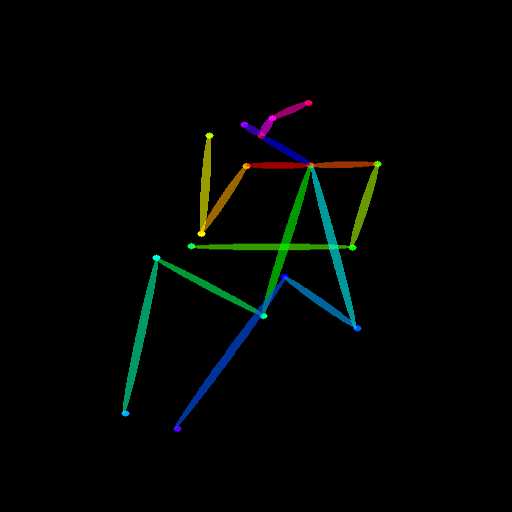

In [17]:
# 이미지를 불러옵니다.
# 주어진 url에서 이미지를 불러오고 openposedetector를 사용하여 인체 자세를 검출한 후
# 이미지를 리사이즈하여 결과를 반환하는 과정을 설명함.
# load_image함수를 사용하여 주어진 url에서 이미지를 불러옴, 이 이미지는 블로그 포스트에서
# 가져온 것으로 보이며 인체가 포함되어 있을 가능성이 큼
openpose_image = load_image("https://search.pstatic.net/common/?src=http%3A%2F%2Fblogfiles.naver.net%2FMjAyNTA0MDhfOTUg%2FMDAxNzQ0MDg5NDM2MDEz.U_29wsnZTiXTfKK2BQFH5wvGEpGrWm4a7ax31vKdN1og.Feox-RLfweok-LbCgTFyBiFvHMNU3rUkPh4yKM-CYEAg.PNG%2Fimage.png&type=sc960_832")

# OpenposeDetector 모델을 사전 학습된 버전으로 로드함, 여기서 /ControlNet은 인체포즈를 감지하는데
# 특화된 모델임
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
# opendetector모델을 사용하여 현재 이미지에 대해 포즈를 감지함, 이 과정에서
# 모델은 이미지 내의 인체 주요 관절들을 찾아내고 이를 기반으로 포즈를 추정함
openpose_image = openpose(openpose_image)
# 포즈가 검출된 이미지를 (512,512) 크기로 리사이즈함, 이는 이후의 이미지 처리나
# 시각화를 위한 전처리단계임
openpose_image = openpose_image.resize((512, 512))
# 최종적으로 인체 포즈가 검출된 이미지를 반환함, 이 이미지는 원본 이미지에
# 인체 포즈 정보가 추가된 형태임
openpose_image
# 위 코드는 이미지에서 인체의 포즈를 자동으로 감지하고 이를 시각화하기 위한 기본적인 프로세스를
# 보여줌, OpenposeDetector는 이미지 내의 주요 관절 위치를 찾아내어 이를 통해 인체의 자세를
# 파악할 수 있게 해줌. 이렇게 생성된 이미지는 인체의 포즈 정보를 시각적으로 나타내며 다양한
# 응용분야에서 활용될 수 있음. 예를 들어, 운동 분석, 애니메이션, 또는 인간-컴퓨터 상호작용 등의
# 분야에서 유용하게 사용될 수 있음

In [18]:
# 이 코드는 두 개의 제어망(ControlNet)을 사용하여 이미지를 생성하는 과정을 설명함.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.
# 두 개의 사전학습된 제어망 모델을 로드함, 각각 canny엣지 검출과 openpose포즈 감지를 위한 모델
# 이 모델들을 리스트controlnets에 저장함
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
controlnets = [controlnet_canny, controlnet_openpose]

# 리스트 controlnets를 파이프라인으로 전달합니다.
# 이미지 생성 파이프라인을 로드함, 기본 모델은 -diffusion-v1-5이며 제어망 리스트와 torch.float16을 사용하여
# 연산을 최적화함
# torch.float16을 사용하여 연산을 최적화함
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)
# 스케줄러를 설정하고 파이프라인을 GPU(cuda)로 이동시켜 연산속도를 높임
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
# 생성할 이미지에 대한 프롬프트와 부정 프롬프트를 정의함, 프롬프트는 생성하고자 하는
# 이미지의 내용을 부정 프롬프트는 피하고자 하는 내용을 기술함
prompt = "A woman in an aquarium, fairy tale, ultra detailed, 4k"
negative_prompt = "blurry, distorted, low quality, extra limbs"
# 난수 생성기의 시드를 고정하여 결과의 재현성을 보장함, 여기서는 시드값을 1로 설정함
generator = torch.manual_seed(1)
# 앞서 생성한 canny 엣지 검출 이미지와 openpose포즈 이미지를 리스트로 묶음 이미지의 내용을 부정 프롬프트는 피하고자 하는 내용을 기술함
prompt = "A woman in an aquarium, fairy tale, ultra detailed, 4k"
negative_prompt = "blurry, distorted, low quality, extra limbs"
# 난수 생성기의 시드를 고정하여 결과의 재현성을 보장함, 여기서는 시드값을 1로 설정함
generator = torch.manual_seed(1)
# 앞서 생성한 canny 엣지 검출 이미지와 openpose포즈 이미지를 리스트로 묶음
images = [canny_image, openpose_image]

# 이미지를 생성합니다.
image_4 = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    generator=generator,
    image=images,  # ControlNet condition 입력
    controlnet_conditioning_scale=[1.0, 0.8]  # 각 controlnet의 영향력 조절
).images[0]

# 생성된 이미지를 저장합니다.
# image.save("/content/drive/MyDrive/aiffel/multi_controlnet_output1.png")
image_4.save("/aiffel/aiffel/multi_controlnet_output_4.png")


# 생성된 이미지를 출력합니다.
image_4

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/multi_controlnet_output_4.png'

In [19]:
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
controlnets = [controlnet_canny, controlnet_openpose]

# 리스트 controlnets를 파이프라인으로 전달합니다.
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다.
prompt = "A fantasy aquarium with magical lights and a walking woman, soft lighting, ultra detailed"
negative_prompt = "blurry, distorted, low quality, extra limbs"

# seed를 지정합니다.
generator = torch.manual_seed(2)

images = [canny_image, openpose_image]

# 이미지를 생성합니다.
image_6 = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    generator=generator,
    image=images,  # ControlNet condition 입력
    controlnet_conditioning_scale=[1.0, 0.8]  # 각 controlnet의 영향력 조절
).images[0]

# 생성된 이미지를 저장합니다.
# image.save("/content/drive/MyDrive/aiffel/multi_controlnet_output1.png")
image_6.save("/aiffel/aiffel/multi_controlnet_output_6.png")


# 생성된 이미지를 출력합니다.
image_6

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/multi_controlnet_output_6.png'

In [20]:
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
controlnets = [controlnet_canny, controlnet_openpose]

# 리스트 controlnets를 파이프라인으로 전달합니다.
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다.
prompt = "A fantasy aquarium with magical lights and a mermaid, soft lighting, cartoon style, ultra detailed"
negative_prompt = "blurry, distorted, low quality, extra limbs"

# seed를 지정합니다.
generator = torch.manual_seed(7)

images = [canny_image, openpose_image]

# 이미지를 생성합니다.
image_7 = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    generator=generator,
    image=images,  # ControlNet condition 입력
    controlnet_conditioning_scale=[1.0, 0.8]  # 각 controlnet의 영향력 조절
).images[0]

# 생성된 이미지를 저장합니다.
# image.save("/content/drive/MyDrive/aiffel/multi_controlnet_output1.png")
image_7.save("/aiffel/aiffel/multi_controlnet_output_7.png")


# 생성된 이미지를 출력합니다.
image_7

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/multi_controlnet_output_7.png'